In [1]:
pip install tensorflow==2.0


Note: you may need to restart the kernel to use updated packages.


In [2]:
# if running in colab, this block chooses tf 2.0:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [3]:
# https://www.pyimagesearch.com/2017/NUM_CLASSES/11/image-classification-with-keras-and-deep-learning/
# https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/
# https://machinelearningmastery.com/save-load-keras-deep-learning-models/
#https://www.learnopencv.com/image-classification-using-convolutional-neural-networks-in-keras/

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
import sys
#import cv2
import matplotlib
from subprocess import check_output
import tensorflow as tf
import matplotlib.pyplot as plt
import math as m

from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical



Using TensorFlow backend.


In [4]:
tf.__version__

'2.0.0'

## uncomment it if we want to redownload the data

In [5]:
'''
import tensorflow_datasets as tfds
#dataset = tfds.image.mnist
# https://www.tensorflow.org/datasets/api_docs/python/tfds/core/DatasetBuilder

malaria_builder = tfds.builder("colorectal_histology")
malaria_info = malaria_builder.info
malaria_builder.download_and_prepare()
datasets = malaria_builder.as_dataset()
datasets
'''

'\nimport tensorflow_datasets as tfds\n#dataset = tfds.image.mnist\n# https://www.tensorflow.org/datasets/api_docs/python/tfds/core/DatasetBuilder\n\nmalaria_builder = tfds.builder("colorectal_histology")\nmalaria_info = malaria_builder.info\nmalaria_builder.download_and_prepare()\ndatasets = malaria_builder.as_dataset()\ndatasets\n'

#uncomment it if we want to redownload and save the data

In [8]:
'''
from numpy import save
# define data
# save to npy file
save('/content/drive/My Drive/Colab Notebooks/machine learning in imaging/final project/image_array_colorectal2.npy', image_array)
files.download('/content/drive/My Drive/Colab Notebooks/machine learning in imaging/final project/image_array_colorectal2.npy')
save('/content/drive/My Drive/Colab Notebooks/machine learning in imaging/final project/label_array_colorectal2.npy', label_array)
files.download('/content/drive/My Drive/Colab Notebooks/machine learning in imaging/final project/label_array_colorectal2.npy')
'''

"\nfrom numpy import save\n# define data\n# save to npy file\nsave('/content/drive/My Drive/Colab Notebooks/machine learning in imaging/final project/image_array_colorectal2.npy', image_array)\nfiles.download('/content/drive/My Drive/Colab Notebooks/machine learning in imaging/final project/image_array_colorectal2.npy')\nsave('/content/drive/My Drive/Colab Notebooks/machine learning in imaging/final project/label_array_colorectal2.npy', label_array)\nfiles.download('/content/drive/My Drive/Colab Notebooks/machine learning in imaging/final project/label_array_colorectal2.npy')\n"

In [9]:
from numpy import load

image_array = load('image_array_colorectal2.npy')


In [10]:
from numpy import load
#image_array = load('/content/drive/My Drive/Colab Notebooks/machine learning in imaging/final project/image_array_colorectal.npy')
label_array = load('label_array_colorectal2.npy')
image_array = image_array/255
# print the array
image_array.shape

(5000, 150, 150, 3)

In [12]:
print(label_array.shape)
print(image_array.shape)

(5000,)
(5000, 150, 150, 3)


In [13]:
x_train, x_test, y_train, y_test = train_test_split( image_array, label_array, test_size=0.25, random_state=42)

In [16]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(3750, 150, 150, 3) (3750,)
(1250, 150, 150, 3) (1250,)


In [17]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

# some parameters

In [22]:
wavelength_ = .5e-3          # units are mm
optical_thickness_ = 20 * wavelength_

wavelength = tf.constant(wavelength_, dtype=tf.complex64)
optical_thickness = tf.constant(optical_thickness_, dtype=tf.complex64)

# RGB color filter

In [24]:
#color_filter_tmp = np.ones([3,150,150])
#initial_value = tf.initializers.GlorotNormal()(shape=(3,1,1)
#color_filter_ = tf.Variable(color_filter_tmp,dtype=tf.float32,trainable=True,name='color_filter_')
color_filter_ = tf.Variable(initial_value = tf.initializers.GlorotNormal()(shape=(3,1,1)),dtype=tf.float32,trainable=True,name='color_filter_')
                                               
#color_filter_ = tf.expand_dims(color_filter_, 0) # add extra axis for batch size


## phase mask


In [25]:
aaa = np.ones((150,150))

In [26]:
optical_phase_mask = tf.Variable(aaa,dtype=tf.float32,trainable=True,name='optical_phase_mask')
optical_phase_mask.dtype
optical_phase_mask = tf.expand_dims(optical_phase_mask, 0) # add extra axis for batch size


## Aperture

In [28]:

num_samples = 150
fxmax= 75
fx = np.linspace(-fxmax, fxmax,num_samples)
fy = fx
[fxx,fyy] = np.meshgrid(fx, fy)
# Take 2D fourier transform of sample


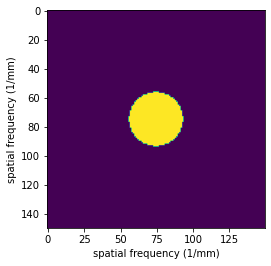

In [29]:
# Define lens numerical aperture as percentage of total width of spatial freqeuncy domain
na = .25 * fxmax
lens_transfer_functiontmp = (np.sqrt(fxx**2+fyy**2))<na
#lens_transfer_function = tf.cast(lens_transfer_function,tf.complex64)

# Plot what the transfer function looks like
plt.imshow(lens_transfer_functiontmp)
plt.xlabel('spatial frequency (1/mm)')
plt.ylabel('spatial frequency (1/mm)')
plt.show()

lens_transfer_function = tf.Variable(lens_transfer_functiontmp,dtype=tf.float32)

lens_transfer_function = tf.cast(lens_transfer_function,tf.complex64)


In [30]:
aperture_phase = tf.Variable(tf.ones([150,150]),dtype=tf.float32,trainable=True,name='aperture_phase')
#aperture_phase = tf.expand_dims(aperture_phase, 0) # add extra axis for batch size


## test physical layer

In [34]:
x_batch_test = x_train [:32]
x_batch_test.shape

(32, 150, 150, 3)

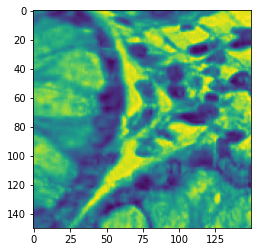

1111
2222
channel G sample 1
channel G sample 1\original


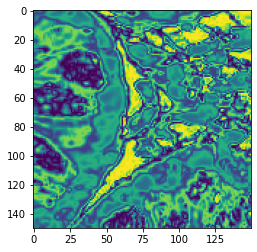

FT_sample_shift


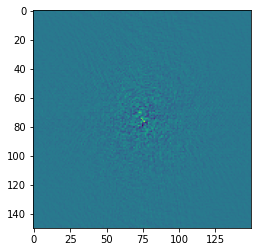

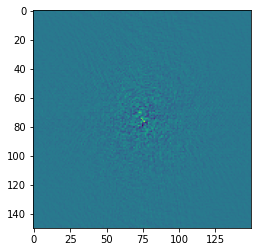

after color filter
lens_transfer_function (150, 150)
aperture_phase2 (150, 150)
aperture (150, 150)
filtered_FT_sample (32, 3, 150, 150)


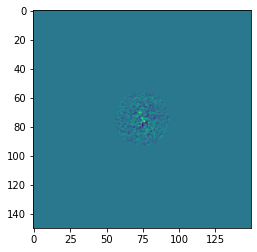

after transfer function 


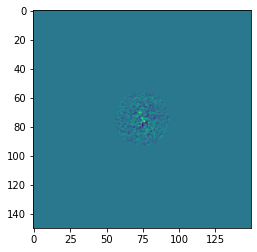

after ifft2d 


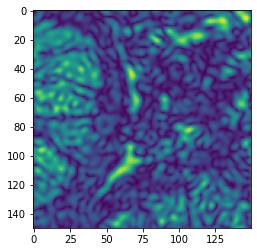

after repermutation :tf.transpose(image, perm=[0,2,3,1]) 


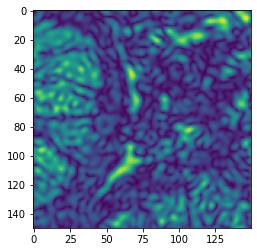

In [36]:

import tensorboard as tb
plt.imshow(x_batch_test[3,:,:,0])
plt.show()

sample = tf.cast(x_batch_test, tf.complex64)
sample_phase = sample
print('1111')
sample = sample * tf.exp(1j * sample_phase*optical_thickness/wavelength) #complex exponential represents phase delay

print('2222')

#### OPTICS #####

sample = tf.transpose(sample, perm=[0,3,1,2])

print('channel G sample 1')

#x = tf_plot(tf.cast((sample[1,1,:,:]),tf.float32))
#embedding_plot = tfplot.figure_to_array(tf.cast((sample[1,1,:,:]),tf.float32))       # ndarray [H, W, 3] uint8
#summary_pb = tb.summary.image_pb('plot_embedding', [embedding_plot])
#summary_writer.write_add_summary(summary_pb, global_step=global_step)

#fig = tfplot.plot(plt.imshow,tf.cast((sample[1,1,:,:]),tf.float32))
print('channel G sample 1\original')

plt.imshow(tf.cast((sample[3,0,:,:]),tf.float32))
plt.show()

#FT_sample = tf.Variable(sample,dtype=tf.complex64,trainable=False)
FT_sample = tf.signal.fft2d(sample)
FT_sample_shift = tf.signal.fftshift(FT_sample,axes=(2,3))

print('FT_sample_shift')
plt.imshow(tf.cast(FT_sample_shift[3,0,:,:],tf.float32))
plt.show()

plt.imshow(tf.cast((tf.signal.fftshift(FT_sample[3,0,:,:])),tf.float32))
plt.show()

#for i in range (3):
 # FT_sample[i].assign(tf.signal.fft2d(sample)
print('after color filter')
color_filter_3 = tf.cast(color_filter_, tf.complex64)



aperture_phase2 = tf.cast(aperture_phase, tf.complex64)
aperture = lens_transfer_function * tf.exp(1j * 2* m.pi* aperture_phase2)
print('lens_transfer_function',lens_transfer_function.shape)
print('aperture_phase2',aperture_phase2.shape)

print('aperture',aperture.shape)

filtered_FT_sample  =tf.multiply(aperture,FT_sample_shift) 
print('filtered_FT_sample',filtered_FT_sample.shape)

#filtered_FT_sample  =tf.multiply(color_filter_3,FT_sample_shift) 
plt.imshow(tf.cast(filtered_FT_sample[3,0,:,:],tf.float32))
plt.show()

print('after transfer function ')
filtered_FT_sample  =tf.multiply(lens_transfer_function,filtered_FT_sample) 
plt.imshow(tf.cast(filtered_FT_sample[3,0,:,:],tf.float32))
plt.show()


print('after ifft2d ')
image = tf.signal.ifft2d(filtered_FT_sample)
plt.imshow(abs(image[3,0,:,:]))
plt.show()


print('after repermutation :tf.transpose(image, perm=[0,2,3,1]) ')
image = tf.transpose(image, perm=[0,2,3,1])
plt.imshow(abs(image[3,:,:,0]))
plt.show()

image = tf.square(tf.abs(image)) #convert it to intensity
#image = tf.square(((image) * tf.math.conj(image))) #convert it to intensity
image = tf.cast(image, tf.float32)



# physical layer RGB

In [38]:
#from PIL import Image
def physical_layer_RGB(x_batch):
  print('123123123')
  print('x_batch shape', x_batch.shape)


  sample = tf.cast(x_batch, tf.complex64)
  print('1111')

  print('2222')

  #### OPTICS #####

  sample = tf.transpose(sample, perm=[0,3,1,2])

  print('channel G sample 1')
  
  #tfplot.plot(plt.imshow,sample[1,1,:,:])
  ##ax.imshow(sample[1,1,:,:])  
  #tfplot.show()
  
  
  #plot_imshow(tf.cast((sample[1,1,:,:]),tf.float32))
  print('channel G sample 1 original')

  #plt.imshow(tf.cast((sample[1,1,:,:]),tf.float32))
  #plt.show()

  #FT_sample = tf.Variable(sample,dtype=tf.complex64,trainable=False)
  FT_sample = tf.signal.fft2d(sample)
  FT_sample_shift = tf.signal.fftshift(FT_sample,axes=(2,3))

  print('after color filter')
  color_filter_2 = tf.square(tf.cast(color_filter_, tf.complex64))
  #color_filter_2 = color_filter_2/tf.reduce_max(color_filter_2)

  filtered_FT_sample  =tf.multiply(color_filter_2,FT_sample_shift) 
  #plt.imshow(tf.cast(filtered_FT_sample[1,1,:,:],tf.float32))
  #plt.show()
  
  #aperture_phase2 = tf.cast(aperture_phase, tf.complex64)
  aperture = lens_transfer_function # * tf.exp(1j * 2* m.pi* aperture_phase2)
  filtered_FT_sample  =tf.multiply(aperture,filtered_FT_sample) 

  print('after transfer function ')
  filtered_FT_sample  =tf.multiply(lens_transfer_function,filtered_FT_sample) 
  #plt.imshow(tf.cast(filtered_FT_sample[1,1,:,:],tf.float32))
  #plt.show()


  print('after ifft2d ')
  image = tf.signal.ifft2d(filtered_FT_sample)
  #plt.imshow(abs(image[1,1,:,:]))
  #plt.show()


  print('after repermutation :tf.transpose(image, perm=[0,2,3,1]) ')
  image = tf.transpose(image, perm=[0,2,3,1])
  #plt.imshow(abs(image[1,:,:,1]))
  #plt.show()

  image = tf.square(tf.abs(image)) #convert it to intensity
  #image = tf.square(((image) * tf.math.conj(image))) #convert it to intensity
  image = tf.cast(image, tf.float32)
  print('image shape after physical layer',image.shape)

  return image

# physical layer phase mask

In [39]:
def physical_layer_phase_mask(x_batch):
  

  x_batch = tf.cast(x_batch, tf.complex64)

  sample = x_batch

#### OPTICS #####
  sample = tf.transpose(sample, perm=[0,3,1,2])

  FT_sample  = tf.signal.fft2d(sample )
  FT_sample_shift = tf.signal.fftshift(FT_sample,axes=(2,3))

  aperture_phase2 = tf.cast(aperture_phase, tf.complex64)
  aperture = lens_transfer_function * tf.exp(1j * 2* m.pi* aperture_phase2)
  filtered_FT_sample  =tf.multiply(aperture, FT_sample_shift) 

  


#### IFFT  and form the image!!! #################
  image = tf.signal.ifft2d(filtered_FT_sample)
  image = tf.transpose(image, perm=[0,2,3,1])

  image = tf.square(tf.abs(image)) #convert it to intensity

  #image = tf.square(((image) * tf.math.conj(image))) #convert it to intensity
  image = tf.cast(image, tf.float32)
  

  return image

# alexnet

In [40]:
# https://www.google.com/search?q=alexnet&sxsrf=ALeKk03nxwjPnSPq77l41iACT4nuWtF0nw:1584470777490&source=lnms&tbm=isch&sa=X&ved=2ahUKEwiGl-XOlaLoAhXtT98KHVwTCIIQ_AUoAXoECA0QAw&biw=1280&bih=529#imgrc=j8y8gy88lYqI-M
#https://github.com/henrypowell87/AlexNet_TF2.0/blob/master/main.py


class Alexnet(tf.keras.Model):
  def __init__(self):
    super(Alexnet, self).__init__()
    self.conv_1 =    tf.keras.layers.Conv2D(filters=96, kernel_size=11, strides=4, padding='same', activation='relu')
    self.pool_1 =    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2),padding="valid")
    self.norm_1 =    tf.keras.layers.BatchNormalization()
    
    self.conv_2 =    tf.keras.layers.Conv2D(filters=256, kernel_size=5, strides=1, padding='same', activation='relu')
    self.pool_2 =    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2),padding="valid")
    self.norm_2 =    tf.keras.layers.BatchNormalization()

    self.conv_3 =    tf.keras.layers.Conv2D(filters=384, kernel_size=3, strides=1, padding='valid', activation='relu')
    self.norm_3 =    tf.keras.layers.BatchNormalization()

    self.conv_4 =    tf.keras.layers.Conv2D(filters=384, kernel_size=3, strides=1, padding='valid', activation='relu')
    self.norm_4 =    tf.keras.layers.BatchNormalization()


    self.conv_5 =    tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu')
    self.pool_5 =    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2),padding="valid")
    self.norm_5 =    tf.keras.layers.BatchNormalization()




    #self.block_5 =    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu')
    self.flat = tf.keras.layers.Flatten()

    self.dense_6 = tf.keras.layers.Dense(units=4096, activation='relu')
    self.drop_6 = tf.keras.layers.Dropout(rate=0.4)
    self.norm_6 =    tf.keras.layers.BatchNormalization()

    self.dense_7 = tf.keras.layers.Dense(units=4096, activation='relu')
    self.drop_7 = tf.keras.layers.Dropout(rate=0.4)
    self.norm_7 =    tf.keras.layers.BatchNormalization()

    self.dense_8 = tf.keras.layers.Dense(units=1000, activation='relu')
    self.drop_8 = tf.keras.layers.Dropout(rate=0.4)
    self.norm_8 =    tf.keras.layers.BatchNormalization()

    self.classifier =  tf.keras.layers.Dense(8, activation='softmax')  # length-10 output for classification


  def call(self, x):
    # ...

    x= self.conv_1(x)
    x= self.pool_1(x)
    x= self.norm_1(x)
    
    x= self.conv_2(x)
    x= self.pool_2(x)
    x= self.norm_2(x)

    x= self.conv_3(x)
    x= self.norm_3(x)

    x= self.conv_4(x)
    x= self.norm_4(x)


    x= self.conv_5(x)
    x= self.pool_5(x)
    x= self.norm_5(x)




    #self.block_5 =    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu')
    x= self.flat(x)

    x= self.dense_6(x)  
    x= self.drop_6(x)  
    x= self.norm_6(x)   

    x= self.dense_7(x)  
    x= self.drop_7(x)  
    x= self.norm_7(x)   

    x= self.dense_8(x) 
    x= self.drop_8(x)  
    x= self.norm_8(x)    

    x = self.classifier(x) 

    #x += input_tensor
    return x



alexnet = Alexnet()

# VGG16

In [41]:
# https://www.kaggle.com/cdeotte/how-to-choose-cnn-architecture-mnist
# best model classify mnist? 784 - [32C3-32C3-32C5S2] - [64C3-64C3-64C5S2] - 128 - 10


class VGG16(tf.keras.Model):
  def __init__(self):
    super(VGG16, self).__init__()

    self.conv_1 =    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu')
    self.conv_12 =    tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu')
    self.pool_1 =    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2),padding="valid")
    

    self.conv_2 =    tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu')
    self.conv_22 =    tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu')
    self.pool_2 =    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2),padding="valid")


    self.conv_3 =    tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu')
    self.conv_32 =    tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu')
    self.conv_33 =    tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu')
    self.pool_3 =    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2),padding="valid")



    self.conv_4 =    tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=1, padding='same', activation='relu')
    self.conv_42 =    tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=1, padding='same', activation='relu')
    self.conv_43 =    tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=1, padding='same', activation='relu')
    self.pool_4 =    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2),padding="valid")



    self.conv_5 =    tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=1, padding='same', activation='relu')
    self.conv_52 =    tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=1, padding='same', activation='relu')
    self.conv_53 =    tf.keras.layers.Conv2D(filters=512, kernel_size=3, strides=1, padding='same', activation='relu')
    self.pool_5 =    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2),padding="valid")



######################## dense ######################################

    self.flat = tf.keras.layers.Flatten()

    self.dense_6 = tf.keras.layers.Dense(units=4096, activation='relu')
    self.drop_6 = tf.keras.layers.Dropout(rate=0.4)
    self.norm_6 =    tf.keras.layers.BatchNormalization()

    self.dense_7 = tf.keras.layers.Dense(units=4096, activation='relu')
    self.drop_7 = tf.keras.layers.Dropout(rate=0.4)
    self.norm_7 =    tf.keras.layers.BatchNormalization()

    self.dense_8= tf.keras.layers.Dense(units=4096, activation='relu')
    self.drop_8 = tf.keras.layers.Dropout(rate=0.4)
    self.norm_8 = tf.keras.layers.BatchNormalization()

    self.classifier =  tf.keras.layers.Dense(8, activation='softmax')  # length-10 output for classification


  def call(self, x):
    
    x= self.conv_1(x)
    x= self.conv_12(x)
    x= self.pool_1(x)
    
    x= self.conv_2(x)
    x= self.conv_22(x)
    x= self.pool_2(x)
    

    x= self.conv_3(x)
    x= self.conv_32(x)
    x= self.conv_32(x)
    x= self.pool_3(x)


    x= self.conv_4(x)
    x= self.conv_42(x)
    x= self.conv_42(x)
    x= self.pool_4(x)


    x= self.conv_5(x)
    x= self.conv_52(x)
    x= self.conv_53(x)
    x= self.pool_5(x)
            
  ######## flatten #################

    x= self.flat(x)

    x= self.dense_6(x)  
    x= self.drop_6(x)  
    x= self.norm_6(x)   

    x= self.dense_7(x)  
    x= self.drop_7(x)  
    x= self.norm_7(x)   

    x= self.dense_8(x) 
    x= self.drop_8(x)  
    x= self.norm_8(x)    

    x = self.classifier(x) 

    #x += input_tensor
    return x



vgg16 = VGG16()

# forward model 

In [42]:
def forward_model_RGB(x_batch):

  physical_out = physical_layer_RGB(x_batch)
  return alexnet(physical_out)


In [43]:
def forward_model_phase_mask(x_batch):
  physical_out = physical_layer_phase_mask(x_batch)
  return alexnet(physical_out)

# define loss and train test step 

In [44]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

optimizer = tf.keras.optimizers.Adam()

In [45]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [46]:
@tf.function
def train_step(images, labels):

  ## add physical layer in here?????
  #### i fix the physical layer for now, just to make sure the cnn is running
  #print('aaa')

  #####
  with tf.GradientTape() as tape:    
    print('bbb')
    #tape.watch(input_illumination_phase)
    #tape.watch(aperture_phase)
    tape.watch(color_filter_)
    #predictions = model(images)
    print('ccc')

    #predictions = forward_model(images,input_illumination_phase,aperture_phase)
    #predictions = forward_model_phase_mask(images)
    predictions = forward_model_RGB(images)
    
    print('ddd')
  
    #predictions = forward_model_RGB(images,aperture_phase)
    #predictions = model(images)
    loss = loss_object(labels, predictions)
    #gradients_aperture = tf.gradients(loss, aperture_phase)
    print('ggg')


  gradients = tape.gradient(loss, alexnet.trainable_variables +[color_filter_] )
  optimizer.apply_gradients(zip(gradients, alexnet.trainable_variables+ [color_filter_]))
  #gradients = tape.gradient(loss,alexnet.trainable_variables + [ aperture_phase] )
  #optimizer.apply_gradients(zip(gradients,alexnet.trainable_variables+[ aperture_phase]))
  
  print('fff')
  #optimizer.apply_gradients(gradients_input_illum, input_illumination_phase)

  train_loss(loss)
  train_accuracy(labels, predictions)
  

In [47]:
@tf.function
def test_step(images, labels):
###  
##
  print('test step')
  #predictions = forward_model(images,input_illumination,aperture)
  predictions = forward_model_RGB(images)

  #predictions = forward_model_phase_mask(images)
  #predictions = model(images)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)
  return predictions
  print(test_accuracy.result())
  #print(test_accuracy.result().eval())

# training!!!!!!! gogogo


In [48]:
EPOCHS = 10
train_acc_list = []
test_acc_list = []
train_loss_list = []
test_loss_list = []
predictions_arr = np.array([])
label_arr = np.array([])

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()
  i = 0
  for images, labels in train_ds:
    i = i+1 # total 1875 batches for training data
    # print('i',i)
    images = images.numpy()
    labels = labels.numpy()
    #images = tf.cast(images, tf.float32)
    #print(images)
    train_step(images, labels)
    if i%20 == 0:
      template_train = 'Epoch {}, Total iteration {}, Train Loss: {}, Train Accuracy: {}'
      print(template_train.format(epoch+1, i, train_loss.result(), train_accuracy.result()*100))
      ## monitor the illuminace phase and aperture phase
  t = 0


  for test_images, test_labels in test_ds:
    t = t + 1 
    # print('t',t)

    predictions = test_step(test_images, test_labels)
    if (epoch == 1):
      # only biuld the confusion matrix by the last epoch
      predictions_arr = np.append(predictions_arr , predictions)
      label_arr = np.append(label_arr, labels)
      print('label_arr.shape',label_arr.shape)
    if t%20 == 0:
      template_test = 'Epoch {}, Total iteration {}, Test Loss: {}, Test Accuracy: {}'
      print(template_test.format(epoch+1, t, test_loss.result(), test_accuracy.result()*100))



  template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
  print('predictions_arr',predictions_arr)
  print('label_arr',label_arr)
  print(template.format(epoch+1,
                        train_loss.result(),
                        train_accuracy.result()*100,
                        test_loss.result(),
                        test_accuracy.result()*100))
  test_acc_list.append(test_accuracy.result()*100)
  train_acc_list.append(train_accuracy.result()*100)
  test_loss_list.append(test_loss.result())
  train_loss_list.append(train_loss.result())

train_loss_arr = np.array(train_loss_list)
test_loss_arr = np.array(test_loss_list)
print('train_loss_arr',train_loss_arr)
print('test_loss_arr',test_loss_arr)

train_acc_arr = np.array(train_acc_list)
test_acc_arr = np.array(test_acc_list)
print('train_acc_arr',train_acc_arr)
print('test_acc_arr',test_acc_arr)


bbb
ccc
123123123
x_batch shape (32, 150, 150, 3)
1111
2222
channel G sample 1
channel G sample 1 original
after color filter
after transfer function 
after ifft2d 
after repermutation :tf.transpose(image, perm=[0,2,3,1]) 
image shape after physical layer (32, 150, 150, 3)
ddd
ggg
fff
bbb
ccc
123123123
x_batch shape (32, 150, 150, 3)
1111
2222
channel G sample 1
channel G sample 1 original
after color filter
after transfer function 
after ifft2d 
after repermutation :tf.transpose(image, perm=[0,2,3,1]) 
image shape after physical layer (32, 150, 150, 3)
ddd
ggg
fff
Epoch 1, Total iteration 20, Train Loss: 2.1063895225524902, Train Accuracy: 14.84375
Epoch 1, Total iteration 40, Train Loss: 2.0053775310516357, Train Accuracy: 16.875
Epoch 1, Total iteration 60, Train Loss: 1.9274308681488037, Train Accuracy: 19.53125
Epoch 1, Total iteration 80, Train Loss: 1.8406763076782227, Train Accuracy: 22.34375
Epoch 1, Total iteration 100, Train Loss: 1.7677180767059326, Train Accuracy: 25.0
bbb

Epoch 5, Total iteration 40, Test Loss: 0.9475072622299194, Test Accuracy: 54.63999938964844
predictions_arr [0.0115021  0.28873399 0.30673897 ... 0.04091215 0.00876952 0.00441107]
label_arr [1. 3. 4. 2. 6. 2. 1. 3. 4. 2. 6. 2. 1. 3. 4. 2. 6. 2. 1. 3. 4. 2. 6. 2.
 1. 3. 4. 2. 6. 2. 1. 3. 4. 2. 6. 2. 1. 3. 4. 2. 6. 2. 1. 3. 4. 2. 6. 2.
 1. 3. 4. 2. 6. 2. 1. 3. 4. 2. 6. 2. 1. 3. 4. 2. 6. 2. 1. 3. 4. 2. 6. 2.
 1. 3. 4. 2. 6. 2. 1. 3. 4. 2. 6. 2. 1. 3. 4. 2. 6. 2. 1. 3. 4. 2. 6. 2.
 1. 3. 4. 2. 6. 2. 1. 3. 4. 2. 6. 2. 1. 3. 4. 2. 6. 2. 1. 3. 4. 2. 6. 2.
 1. 3. 4. 2. 6. 2. 1. 3. 4. 2. 6. 2. 1. 3. 4. 2. 6. 2. 1. 3. 4. 2. 6. 2.
 1. 3. 4. 2. 6. 2. 1. 3. 4. 2. 6. 2. 1. 3. 4. 2. 6. 2. 1. 3. 4. 2. 6. 2.
 1. 3. 4. 2. 6. 2. 1. 3. 4. 2. 6. 2. 1. 3. 4. 2. 6. 2. 1. 3. 4. 2. 6. 2.
 1. 3. 4. 2. 6. 2. 1. 3. 4. 2. 6. 2. 1. 3. 4. 2. 6. 2. 1. 3. 4. 2. 6. 2.
 1. 3. 4. 2. 6. 2. 1. 3. 4. 2. 6. 2. 1. 3. 4. 2. 6. 2. 1. 3. 4. 2. 6. 2.]
Epoch 5, Loss: 0.9999597668647766, Accuracy: 52.0533332824707, Test Loss: 0.94

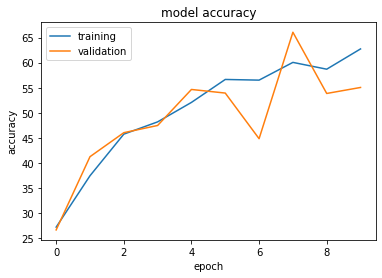

In [49]:
plt.plot(train_acc_arr)
plt.plot(test_acc_arr)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

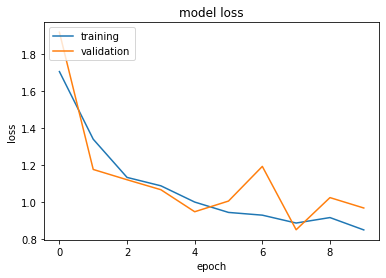

In [50]:
plt.plot(train_loss_arr)
plt.plot(test_loss_arr)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()